<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Time_use_shares_with_vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [0]:
from tensorflow.keras import backend as K   # Use tensorflow.keras
K.clear_session()

In [0]:

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow import set_random_seed

from numpy.random import seed

import numpy as np

In [0]:
epochs = 200
batch_size = 128     # Batch size is 32 instead of 16.

In [0]:
callback_list = [
                 keras.callbacks.ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.5,
                     patience = 10,
                     verbose =1 #true
                 )
]

Use PReLU instead of ReLU.

In [0]:
def make_vae( 
    img_shape = (389+1, ),
    latent_dim = 1, 
    dense_width = 600,
    l2_penalty=0.00001,
    l1_penalty=0.0,
    encoder_dropout_rate=0.5,
    decoder_dropout_rate=0.0,
    entanglement_penalty = 1,
    hidden_n = 1):
  
  input_img = keras.Input(shape=img_shape)

  # The last input indicate to the network whether this is validation
  is_validation = input_img[:,-1] 
  input_data = input_img[:,:-1] 
  # if is_validation[0] == 0:
  #   input_data += K.random_normal(shape=input_data.shape,stddev=0.3)


  # Test the PReLU

  # x = layers.Dense(dense_width, activation='relu',
  #                 kernel_regularizer=regularizers.l1_l2(
  #                     l1=l1_penalty,l2=l2_penalty))(input_data)
  x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), \
                   kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(input_data)



  x = layers.Dropout(encoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)), 
                     kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(encoder_dropout_rate)(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)
  
  # Reduce sampling variance to near zero on validation (idea credit: Shahaf Grofit)
  is_validation_change = is_validation*100
  z_log_var = keras.layers.Subtract()([z_log_var, is_validation_change])
 
  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        is_validation = x[:,-1] 
        input_data = x[:,:-1] 
        x = K.flatten(input_data)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.mse(x, z_decoded)

        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) 
            - entanglement_penalty*K.exp(z_log_var), axis=-1)
        
        # Penalize for variance, but only in training 
        return K.mean(xent_loss + (1-is_validation)*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x    

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  encoder = Model(input_img,z_mean) # Maybe better if Model(input_data,z_mean)

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])
  print(decoder_input.shape)
  x = layers.Dense(dense_width, 
                   activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                   kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(decoder_input)
  x = layers.Dropout(decoder_dropout_rate)(x)

  for i in range(hidden_n):
    x = layers.Dense(dense_width, 
                     activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                      kernel_regularizer=regularizers.l1_l2(
                        l1=l1_penalty,l2=l2_penalty))(x)
    x = layers.Dropout(decoder_dropout_rate)(x)


  x = layers.Dense(img_shape[0]-1, 
                   activation=layers.PReLU(alpha_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty)),
                    kernel_regularizer=regularizers.l1_l2(
                      l1=l1_penalty,l2=l2_penalty))(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  # We call our custom layer on the input and the decoded output,
  # to obtain the score. Note that the objective is computed by 
  # this special final layer.
  y = CustomVariationalLayer()([input_img, z_decoded])

  vae = Model(input_img, y)

  vae.compile(optimizer='adam', loss=None) 
  
  return (vae, encoder, decoder)

In [56]:
import pandas as pd 
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,540,330,0,35,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,580,95,0,75,0,35,60,25,15,0,0,0,0,0,50,0,0,80,0,309,20,60,0,0,0,5,0,0,0,0,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450,60,0,170,0,90,105,0,20,0,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,0,0,40,0,145,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,450,65,680,70,0,30,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,570,90,0,120,0,0,60,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [57]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.571572,0.831832,0.000000,0.304805,0.000000,0.311311,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.997387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.693193,0.400901,0.000000,0.646146,0.000000,0.508008,0.825325,0.782282,0.791792,0.000000,0.0,0.000000,0.000000,0.000000,0.919920,0.0,0.000000,0.961962,0.0,0.995862,0.851852,0.958458,0.000000,0.000000,0.0,0.871371,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.877878,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.262262,0.304304,0.000000,0.958959,0.000000,0.903403,0.937437,0.000000,

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

In [64]:
seed(100)
set_random_seed(100)
(vae, encoder, decoder) = make_vae(l2_penalty=0.000001,
                                   l1_penalty=0.0, 
                                   encoder_dropout_rate=0.2)  # encoder_dropout_rate 0.2
vae.summary()

fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = callback_list
    )

(?, 1)
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 390)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_17 (T [(None, 389)]        0           input_17[0][0]                   
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 600)          234600      tf_op_layer_strided_slice_17[0][0
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 600)          0           dense_58[0][0]                   
____________________________________________________________________________________

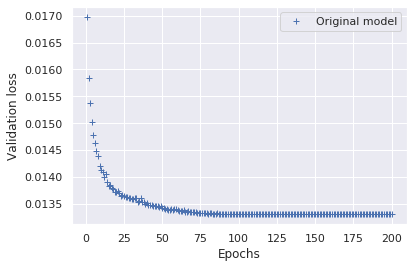

In [65]:
epochs_grid = range(1, epochs+1)
val_loss1 = fitted.history['val_loss']
#val_loss2 = fitted2.history['val_loss']


import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs_grid, val_loss1, 'b+', label='Original model')
# "bo" is for "blue dot"
#plt.plot(epochs_grid, val_loss2, 'bo', label='Alternative model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

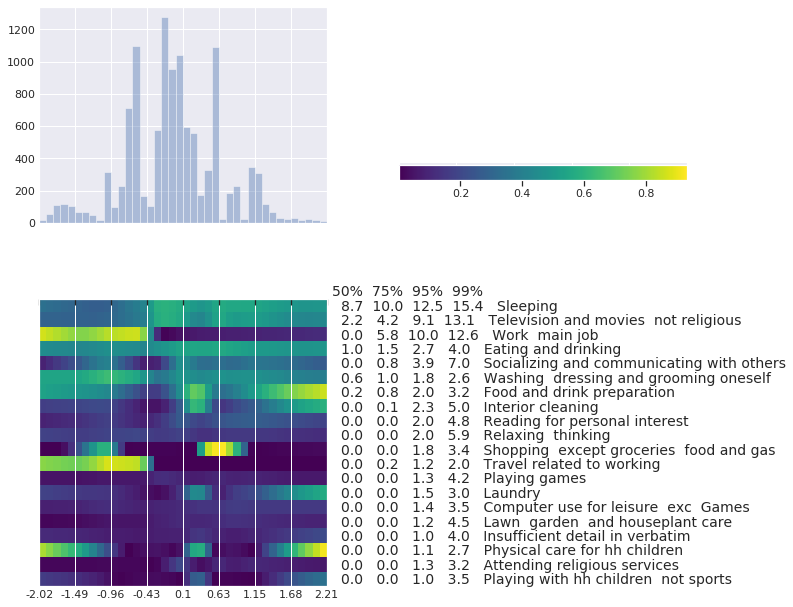

In [66]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sns.set()
sns.set_style("darkgrid")

def plot_types(decoder, data, n_type = 40, each_hight = 20, approx_width=400, 
               n_activity =  20, lowest_percentile= 0.1, 
               highest_percentile = 99.9, figsize=(10, 10),
               cmap='viridis', n_xlabels=9, spacing = -0.02, standard_scaler=True):
  
  # definitions for the axes
  left, width = 0.05, 0.40
  bottom, height = 0.025, 0.65
  

  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, 0.3]
  rect_colorbar = [left+width+0.1, bottom + height + spacing +0.05, width, 0.03]

  # start with a rectangular Figure
  plt.figure(figsize=figsize)

  ax_scatter = plt.axes(rect_scatter)
  ax_scatter.tick_params(direction='in', top=True, right=True)
  ax_histx = plt.axes(rect_histx)
  ax_histx.tick_params(direction='in', labelbottom=False)
  ax_colorbar = plt.axes(rect_colorbar)
  ax_colorbar.tick_params(direction='in', labelbottom=False, labelleft=False)

  each_width = np.int(np.ceil(approx_width/n_type))
  figure = np.zeros((each_hight*n_activity,n_type*each_width))
  # Linearly spaced coordinates on the unit square were transformed
  # through the inverse CDF (ppf) of the Gaussian
  # to produce values of the latent variables z,
  # since the prior of the latent space is Gaussian
  
  # We need to add a column of ones to indicate validation
  test_examples = data.shape[0]
  flag_1 = np.ones((test_examples,1),dtype=data.values.dtype)
  data = np.concatenate((data.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  #print(lowest,highest)

  grid_x = np.linspace(lowest, highest, n_type)

  for i, xi in enumerate(grid_x):
      z_sample = np.array([[xi]])
      x_decoded = decoder.predict(z_sample)
      figure[0:n_activity*each_hight,i*each_width : (i + 1)*each_width] = \
      np.repeat(x_decoded[0,0:n_activity],each_hight).reshape(n_activity*each_hight,1)

  if standard_scaler:
    figure=np.transpose(figure)
    scaler = StandardScaler()
    figure=scaler.fit_transform(figure)
    figure=np.transpose(figure)

  im = ax_scatter.imshow(figure, cmap=cmap)
  plt.colorbar(im, ax= ax_colorbar, orientation='horizontal', fraction=1)

  prec = pd.DataFrame(np.percentile(df,[50, 75, 95, 99],axis=0))

  ax_scatter.text(1.02*n_type*each_width,
                  0.8*each_hight -each_hight, '50%  75%  95%  99%', fontsize=14)

  for i in range(n_activity):

    ax_scatter.text(1.02*n_type*each_width,
                    0.8*each_hight+i*each_hight, 
                    '{:5.1f} {:5.1f} {:5.1f} {:5.1f}   '.format(prec.iloc[0,i]/60, 
                                                             prec.iloc[1,i]/60,
                                                             prec.iloc[2,i]/60,
                                                             prec.iloc[3,i]/60)  
                    + df.columns[i].replace("_", " ")
, fontsize=14)

  bins=np.append(grid_x-(grid_x[1]-grid_x[0])/2,
                 grid_x[n_type-1]+(grid_x[1]-grid_x[0])/2)

  
  ax_scatter.set_xticks( np.linspace(0,n_type*each_width,n_xlabels))
  ax_scatter.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))  
  ax_scatter.set_yticks([])

  ax_histx.set_xticks( np.linspace(bins[0], bins[n_type], n_xlabels))
  ax_histx.set_xticklabels(np.round(np.linspace(bins[0], bins[n_type], n_xlabels),
                                      decimals=2))
  
  sns.distplot(encoded_data,ax=ax_histx,bins=bins,kde=False,
               rug=False).set_xlim(bins[0],bins[n_type])
  
  plt.savefig('type_plot.png')

  plt.show()

plot_types(decoder,qt, standard_scaler = False);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


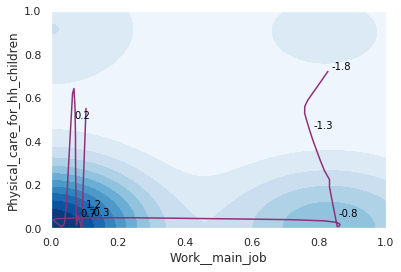

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

def encode_plot2d(
    data,
    encoder, 
    decoder,
    ax=plt.axes(),
    x_col = 'Work__main_job',
    y_col = 'Physical_care_for_hh_children',
    lowest_percentile=1,
    highest_percentile = 99,
    n=70,
    step=10):

  flag_1 = np.ones((data.shape[0],1),dtype=data.values.dtype)
  data_ = np.concatenate((data.values,flag_1),axis=-1)
  encoded_data=encoder.predict(data_)

  lowest=np.percentile(encoded_data, lowest_percentile)
  highest=np.percentile(encoded_data, highest_percentile)

  grid_x = np.linspace(lowest, highest, n)

  filtered=pd.DataFrame((decoder.predict(grid_x)))
  filtered.columns = df.columns
  
  sns.kdeplot(data[x_col], data[y_col], cmap="Blues", shade=True, bw=.2, cut=0, legend=True, ax=ax)
  sns.lineplot(x = filtered[x_col], y=filtered[y_col], linewidth=1.5, 
                color= '#8E3179', sort=False, ax=ax)
  
  for i in range(0,n,step):
      ax.text(filtered[x_col][i]+0.01, filtered[y_col][i]+0.01, np.round(grid_x[i],1), 
              horizontalalignment='left', size='small', color='black')
  
  plt.savefig(x_col+'_'+y_col+'.png')
  plt.show()
  
encode_plot2d(qt,encoder,decoder, ax=plt.axes())

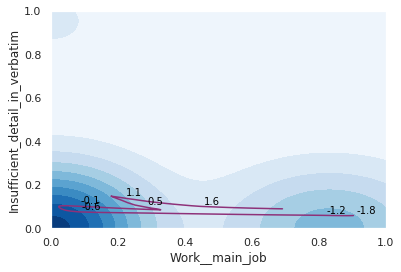

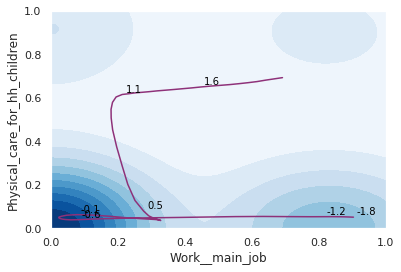

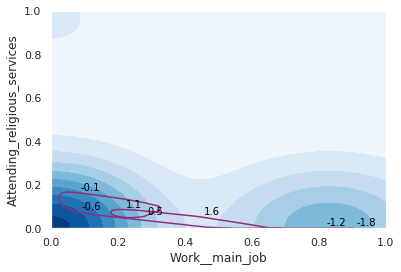

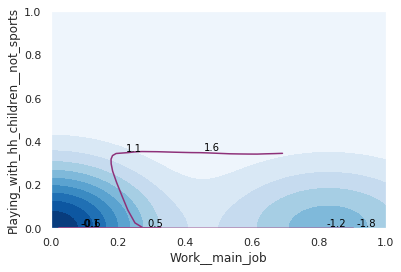

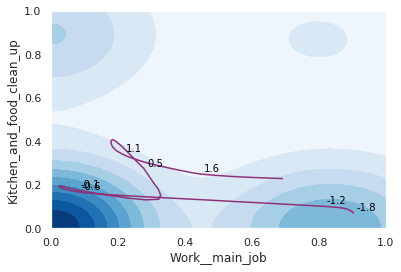

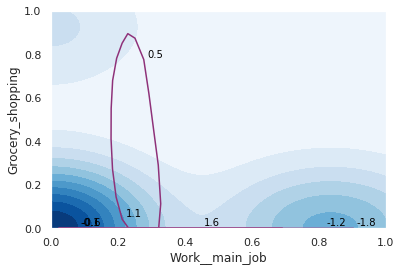

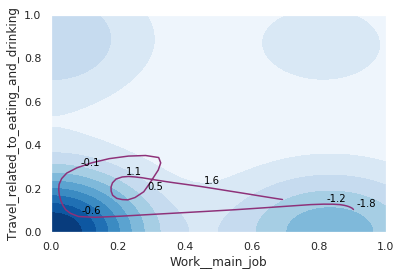

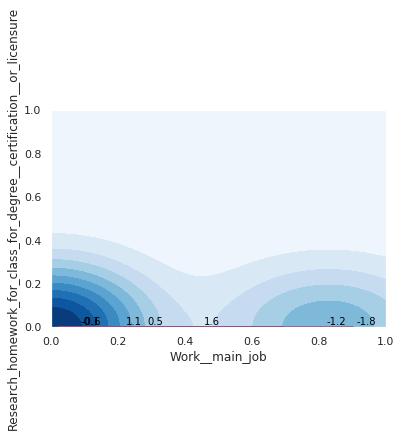

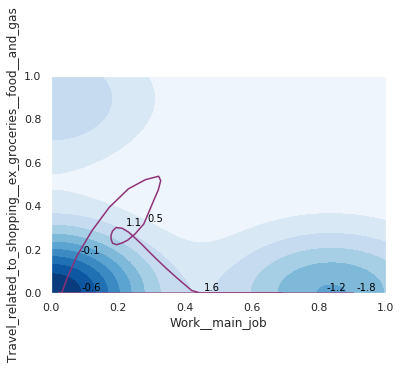

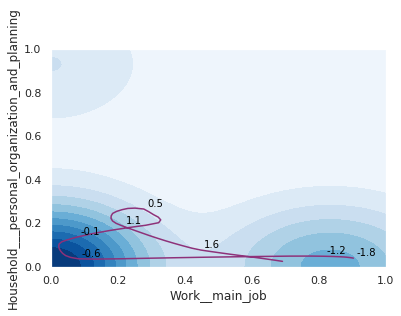

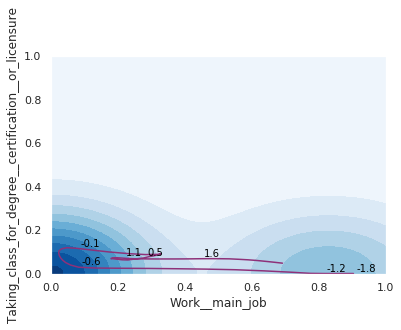

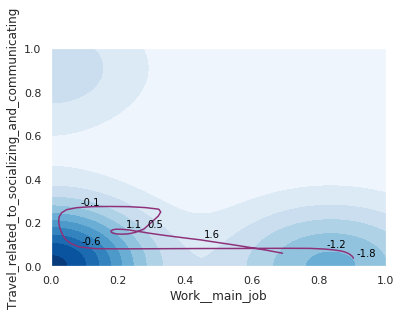

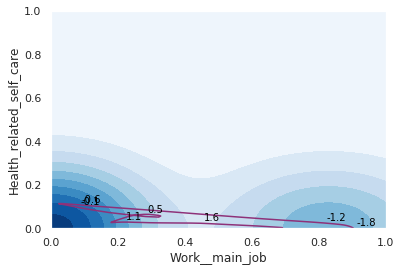

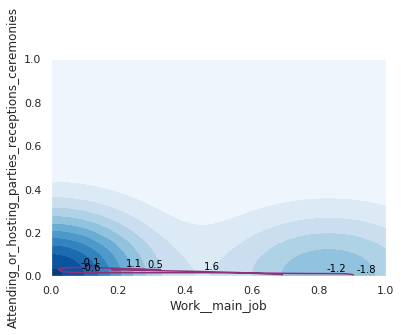

In [0]:
for field in filtered.columns[16:30]:
    
     encode_plot2d(qt,encoder,decoder, ax=plt.axes(), y_col=field)

In [0]:

flag_1 = np.ones((qt.shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.values,flag_1),axis=-1)
encoded_data=encoder.predict(data)
pd.DataFrame(encoded_data)

,0
0,1.456341
1,0.761256
2,0.625747
3,0.168303
4,-0.602680
...,...
11380,-0.539688
11381,-1.428945
11382,-1.378089
11383,-0.553676


In [0]:
filtered=pd.DataFrame((decoder.predict(encoded_data)))
filtered.columns = df.columns
filtered

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.439737,0.361147,0.360049,0.509219,0.276026,0.454134,0.488052,0.299562,0.130920,0.133553,0.107813,0.296132,0.065597,0.208863,0.098240,0.052736,0.111770,0.637464,0.066695,0.350314,0.274664,0.000000,0.229335,0.0,0.091325,0.110215,0.067057,0.135927,0.024613,0.023077,0.015940,0.066895,0.580220,0.026918,0.000000,0.040893,0.066111,0.034215,0.038363,0.007048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.508732,0.462906,0.188888,0.510707,0.325861,0.456287,0.628190,0.392090,0.224443,0.151131,0.234793,0.110622,0.089600,0.318586,0.151159,0.100579,0.141558,0.415891,0.058963,0.237745,0.404630,0.736102,0.162238,0.0,0.223569,0.249631,0.068003,0.148499,0.033660,0.026852,0.017794,0.086754,0.375141,0.039340,0.724443,0.051788,0.115397,0.054188,0.054458,0.028496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
filtered-qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,-0.131834,-0.470685,0.360049,0.204414,0.276026,0.142823,0.488052,0.299562,0.130920,0.133553,0.107813,0.296132,0.065597,0.208863,0.098240,0.052736,0.111770,0.637464,0.066695,0.350314,0.274664,0.000000,0.229335,-0.997387,0.091325,0.110215,0.067057,0.135927,0.024613,0.023077,0.015940,0.066895,0.580220,0.026918,0.000000,0.040893,0.066111,0.034215,0.038363,0.007048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.184461,0.062005,0.188888,-0.135439,0.325861,-0.051721,-0.197135,-0.390192,-0.567349,0.151131,0.234793,0.110622,0.089600,0.318586,-0.768761,0.100579,0.141558,-0.546071,0.058963,-0.758116,-0.447221,-0.222356,0.162238,0.000000,0.223569,-0.621740,0.068003,0.148499,0.033660,0.026852,0.017794,0.086754,0.375141,0.039340,-0.153434,0.051788,0.115397,0.054188,0.054458,0.028496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [0]:
import time
from google.colab import files

In [0]:
files.download('type_plot.png') 

MessageError: ignored

In [0]:
pd.DataFrame(encoded_data).to_csv("encoded_data.csv", header=False, index=False)


In [0]:
files.download('encoded_data.csv') 

In [0]:
encoder.save_weights('encoder')

In [0]:
files.download('encoder.index') 
files.download('encoder.data-00000-of-00002') 
files.download('encoder.data-00001-of-00002') 

In [0]:
decoder.save_weights('decoder')

In [0]:
files.download('decoder.index') 
files.download('decoder.data-00000-of-00002') 
files.download('decoder.data-00001-of-00002') 

In [0]:
files.download('checkpoint') 